In [1]:
%pip install pandas matplotlib seaborn scikit-learn xgboost streamlit streamlit-option-menu psutil shap plotly

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import os # <-- Added this missing import
from sklearn.preprocessing import OrdinalEncoder

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier

# Set plot style
sns.set_style("whitegrid")
print("Libraries imported successfully.")

Libraries imported successfully.


In [3]:
# Load the dataset
df = pd.read_csv("Employee_Dataset.csv")

# Clean column names and data by stripping whitespace
df.columns = df.columns.str.strip()
for col in df.select_dtypes(['object']).columns:
    df[col] = df[col].str.strip()

# Replace '?' with 'Others'
cols_with_question_mark = ['workclass', 'occupation', 'native-country']
for col in cols_with_question_mark:
    df[col] = df[col].replace('?', 'Others')

print("Data loaded and '?' values handled.")

# Drop redundant or unnecessary columns
columns_to_drop = ['race', 'education', 'relationship', 'fnlwgt']
df_cleaned = df.drop(columns=columns_to_drop)
print(f"Dropped columns: {', '.join(columns_to_drop)}")
print(f"Data shape after dropping columns: {df_cleaned.shape}")

Data loaded and '?' values handled.
Dropped columns: race, education, relationship, fnlwgt
Data shape after dropping columns: (48842, 11)


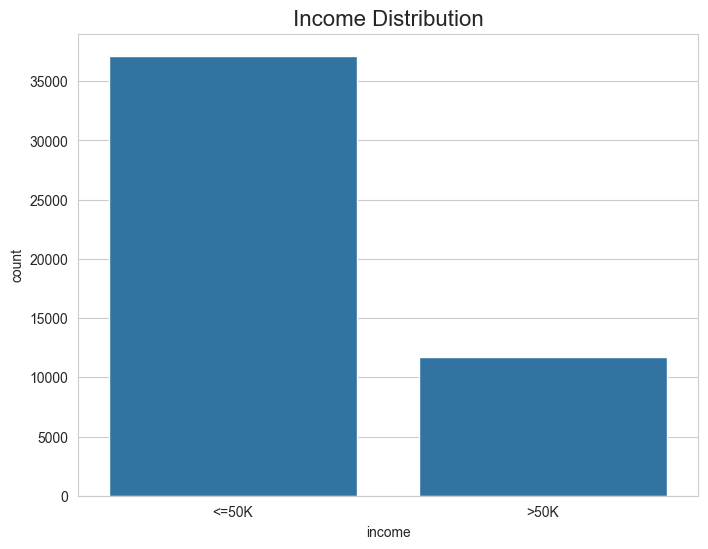

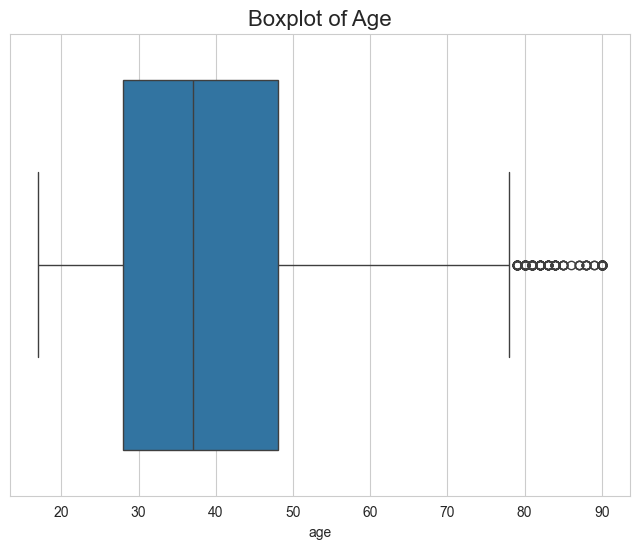

In [4]:
# --- Visualizations ---

# 1. Visualize the target variable 'income'
plt.figure(figsize=(8, 6))
sns.countplot(x='income', data=df_cleaned)
plt.title('Income Distribution', fontsize=16)
plt.show()

# 2. Visualize 'age' to check distribution
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_cleaned['age'])
plt.title('Boxplot of Age', fontsize=16)
plt.show()

In [5]:
df_filtered = df_cleaned.copy()
print(f"Starting with {df_filtered.shape[0]} rows.")

# 1. Filter by Age
print(f"\nFiltering age to be between 20 and 65...")
df_filtered = df_filtered[(df_filtered['age'] >= 20) & (df_filtered['age'] <= 65)]
print(f"Shape after age filtering: {df_filtered.shape}")

# 2. Filter Low-Frequency Categories
columns_to_process = ['workclass', 'marital-status', 'occupation', 'gender', 'native-country']
for col in columns_to_process:
    value_counts = df_filtered[col].value_counts()
    to_remove = value_counts[value_counts < 100].index
    if len(to_remove) > 0:
        print(f"\nIn '{col}', removing categories with counts < 100: {list(to_remove)}")
        df_filtered = df_filtered[~df_filtered[col].isin(to_remove)]
        print(f"Shape after filtering '{col}': {df_filtered.shape}")

print(f"\nFinal dataset contains {df_filtered.shape[0]} rows after all filtering.")

Starting with 48842 rows.

Filtering age to be between 20 and 65...
Shape after age filtering: (44529, 11)

In 'workclass', removing categories with counts < 100: ['Without-pay', 'Never-worked']
Shape after filtering 'workclass': (44511, 11)

In 'marital-status', removing categories with counts < 100: ['Married-AF-spouse']
Shape after filtering 'marital-status': (44478, 11)

In 'occupation', removing categories with counts < 100: ['Armed-Forces']
Shape after filtering 'occupation': (44463, 11)

In 'native-country', removing categories with counts < 100: ['Italy', 'Japan', 'Guatemala', 'Columbia', 'Vietnam', 'Poland', 'Haiti', 'Taiwan', 'Portugal', 'Iran', 'Greece', 'Nicaragua', 'Ecuador', 'Peru', 'France', 'Ireland', 'Hong', 'Thailand', 'Cambodia', 'Trinadad&Tobago', 'Outlying-US(Guam-USVI-etc)', 'Laos', 'Yugoslavia', 'Honduras', 'Scotland', 'Hungary', 'Holand-Netherlands']
Shape after filtering 'native-country': (43216, 11)

Final dataset contains 43216 rows after all filtering.


In [6]:
# Feature Engineering
df_filtered["net_capital"] = df_filtered["capital-gain"] - df_filtered["capital-loss"]

# Define feature lists
num_features = ["age", "educational-num", "hours-per-week", "net_capital"]
cat_features = ["workclass", "marital-status", "occupation", "gender", "native-country"]
target = "income"

# Isolate features (X) and target (y)
X = df_filtered.drop(columns=[target, 'capital-gain', 'capital-loss'])
y = (df_filtered[target] == ">50K").astype(int)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Feature engineering complete and data is split.")

Feature engineering complete and data is split.


In [7]:
import json

# Create directories if they don't exist
MODEL_DIR = "Models"
ASSETS_DIR = "Assets"
if not os.path.exists(MODEL_DIR): os.makedirs(MODEL_DIR)
if not os.path.exists(ASSETS_DIR): os.makedirs(ASSETS_DIR)

# Preprocessors
preprocessor_ohe = ColumnTransformer(transformers=[
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features),
])
preprocessor_ordinal = ColumnTransformer(transformers=[
    ("num", StandardScaler(), num_features),
    ("cat", OrdinalEncoder(handle_unknown="error"), cat_features),
])

# Define Models
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=scale_pos_weight),
    "MLP Classifier": MLPClassifier(random_state=42, max_iter=500)
}

model_performance = []
roc_data = {}

# Loop, Train, and Evaluate
for name, model in models.items():
    preprocessor_to_use = preprocessor_ordinal if name == "XGBoost" else preprocessor_ohe
    pipe = Pipeline(steps=[("preprocessor", preprocessor_to_use), ("classifier", model)])
    
    print(f"Training {name}...")
    pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    
    model_performance.append({
        "Model": name, "Accuracy": accuracy_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred), "ROC AUC": roc_auc_score(y_test, y_proba)
    })
    
    # Calculate and store ROC curve data for the app
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_data[name] = {'fpr': fpr.tolist(), 'tpr': tpr.tolist()}
    
    save_path = os.path.join(MODEL_DIR, f"{name.replace(' ', '_').lower()}_pipeline.pkl")
    joblib.dump(pipe, save_path)
    print(f"Saved pipeline for {name} to '{save_path}'")

# Save performance and ROC data to the Assets folder
performance_df = pd.DataFrame(model_performance).sort_values(by="F1 Score", ascending=False).reset_index(drop=True)
performance_df.to_csv(os.path.join(ASSETS_DIR, "model_performance.csv"), index=False)
with open(os.path.join(ASSETS_DIR, 'roc_data.json'), 'w') as f:
    json.dump(roc_data, f)
    
# Save a sample of the training data for SHAP
X_train.sample(100, random_state=42).to_csv(os.path.join(ASSETS_DIR, "X_train_sample.csv"), index=False)
print("\nAssets for app (performance data, ROC data, and data sample) saved to 'Assets' folder.")

Training Logistic Regression...
Saved pipeline for Logistic Regression to 'Models\logistic_regression_pipeline.pkl'
Training K-Nearest Neighbors...


f:\Program_Files\Anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "f:\Program_Files\Anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py", line 199, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "f:\Program_Files\Anaconda\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "f:\Program_Files\Anaconda\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "f:\Program_Files\Anaconda\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.Crea

Saved pipeline for K-Nearest Neighbors to 'Models\k-nearest_neighbors_pipeline.pkl'
Training Random Forest...
Saved pipeline for Random Forest to 'Models\random_forest_pipeline.pkl'
Training XGBoost...


f:\Program_Files\Anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:16:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Saved pipeline for XGBoost to 'Models\xgboost_pipeline.pkl'
Training MLP Classifier...
Saved pipeline for MLP Classifier to 'Models\mlp_classifier_pipeline.pkl'

Assets for app (performance data, ROC data, and data sample) saved to 'Assets' folder.


In [8]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib
import os
import shap
import json
import plotly.graph_objects as go
from streamlit_option_menu import option_menu
import matplotlib.pyplot as plt

# --- Page Configuration ---
st.set_page_config(
    page_title="Salary Prediction App",
    page_icon="💼",
    layout="wide"
)

# --- Custom CSS ---
st.markdown("""
<style>
    .stApp {
        background: linear-gradient(135deg, #0f2027, #203a43, #2c5364);
        color: #FFFFFF;
    }
    [data-testid="stSidebar"] { background-color: rgba(0, 0, 0, 0.2); }
</style>
""", unsafe_allow_html=True)


# --- Backend: Load Assets ---
MODEL_DIR = "Models"
ASSETS_DIR = "Assets"

@st.cache_resource
def load_model(model_name):
    path = os.path.join(MODEL_DIR, f"{model_name.replace(' ', '_').lower()}_pipeline.pkl")
    try:
        return joblib.load(path)
    except FileNotFoundError:
        return None

@st.cache_data
def load_data(file_name):
    path = os.path.join(ASSETS_DIR, file_name)
    try:
        if file_name.endswith('.csv'):
            return pd.read_csv(path)
        elif file_name.endswith('.json'):
            with open(path, 'r') as f:
                return json.load(f)
    except FileNotFoundError:
        return None

# --- UI Sidebar ---
with st.sidebar:
    st.title("Salary Prediction")
    page = option_menu(
        None, ["Prediction App", "Model Performance"],
        icons=["cash-coin", "bar-chart-line"], menu_icon="cast", default_index=0
    )
    st.info("Navigate between the prediction tool and the model performance analysis.")


# --- Prediction App Page ---
if page == "Prediction App":
    st.header("💵 Predict an Individual's Salary")
    
    MODEL_FILES = {
        "XGBoost": "xgboost_pipeline.pkl", "Random Forest": "random_forest_pipeline.pkl",
        "MLP Classifier": "mlp_classifier_pipeline.pkl", "Logistic Regression": "logistic_regression_pipeline.pkl",
        "K-Nearest Neighbors": "k-nearest_neighbors_pipeline.pkl"
    }
    selected_model_name = st.selectbox("Choose a Model for Prediction", list(MODEL_FILES.keys()))

    # Input fields
    workclass_options = ['Private', 'Self-emp-not-inc', 'Local-gov', 'Others', 'State-gov', 'Self-emp-inc', 'Federal-gov']
    marital_status_options = ['Married-civ-spouse', 'Never-married', 'Divorced', 'Separated', 'Widowed']
    occupation_options = ['Prof-specialty', 'Craft-repair', 'Exec-managerial', 'Adm-clerical', 'Sales', 'Other-service', 'Machine-op-inspct', 'Others', 'Transport-moving', 'Handlers-cleaners', 'Farming-fishing', 'Tech-support', 'Protective-serv']
    native_country_options = ['United-States', 'Mexico', 'Others', 'Philippines', 'Germany', 'Puerto-Rico', 'Canada', 'El-Salvador', 'India', 'Cuba', 'England', 'China', 'South', 'Jamaica', 'Italy', 'Dominican-Republic']
    
    col1, col2 = st.columns(2)
    with col1:
        age = st.slider("Age", 20, 65, 35)
        workclass = st.selectbox("Work Class", workclass_options)
        marital_status = st.selectbox("Marital Status", marital_status_options)
    with col2:
        educational_num = st.slider("Years of Education", 1, 16, 10)
        hours_per_week = st.slider("Hours per Week", 1, 99, 40)
        gender = st.selectbox("Gender", ['Male', 'Female'])
    
    occupation = st.selectbox("Occupation", occupation_options)
    native_country = st.selectbox("Native Country", native_country_options)

    if st.button("Predict Income", type="primary"):
        model_pipeline = load_model(selected_model_name)
        
        if model_pipeline:
            input_data = pd.DataFrame({
                'age': [age],
                'educational-num': [educational_num],
                'hours-per-week': [hours_per_week],
                'net_capital': [0],
                'workclass': [workclass],
                'marital-status': [marital_status],
                'occupation': [occupation],
                'gender': [gender],
                'native-country': [native_country]
            })
            
            # The debugging line has been removed from here.

            try:
                prediction = model_pipeline.predict(input_data)[0]
                prediction_proba = model_pipeline.predict_proba(input_data)[0]
                
                st.subheader("Prediction Result")
                col1, col2 = st.columns(2)
                with col1:
                    if prediction == 1:
                        st.success("Predicted Income: **> $50K**")
                    else:
                        st.info("Predicted Income: **<= $50K**")
                with col2:
                    prob = prediction_proba[1] if prediction == 1 else prediction_proba[0]
                    st.metric(label="Confidence", value=f"{prob:.2%}")
            
            except Exception as e:
                st.error(f"An error occurred during prediction: {e}")

# --- Model Performance Page ---
if page == "Model Performance":
    st.header("📊 Model Performance & Selection")
    
    performance_df = load_data("model_performance.csv")
    roc_data = load_data("roc_data.json")
    
    if performance_df is not None:
        best_model = performance_df.iloc[0]
        st.subheader("Best Performing Model")
        
        col1, col2, col3 = st.columns(3)
        with col1:
            st.metric("🏆 Best Model", best_model['Model'])
        with col2:
            st.metric("F1 Score", f"{best_model['F1 Score']:.4f}")
        with col3:
            st.metric("ROC AUC", f"{best_model['ROC AUC']:.4f}")

        st.markdown("---")
        st.subheader("All Model Scores")
        st.dataframe(performance_df.style.format({
            'Accuracy': '{:.4f}',
            'F1 Score': '{:.4f}',
            'ROC AUC': '{:.4f}'
        }))
        
        st.subheader("Why was the Best Model Chosen?")
        st.markdown(f"""
        The **{best_model['Model']}** model was selected as the best performer based on its **F1 Score**. This metric is crucial because the dataset is imbalanced. The F1 score provides a balance between Precision and Recall, making it the most reliable indicator of a model's true performance on this task.
        """)
        
        if roc_data:
            st.subheader("ROC Curve Comparison")
            fig = go.Figure()
            fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)
            
            for name, data in roc_data.items():
                if name in performance_df['Model'].values:
                    auc = performance_df.loc[performance_df['Model'] == name, 'ROC AUC'].iloc[0]
                    fig.add_trace(go.Scatter(x=data['fpr'], y=data['tpr'], name=f"{name} (AUC={auc:.4f})", mode='lines'))

            fig.update_layout(
                xaxis_title='False Positive Rate', yaxis_title='True Positive Rate',
                yaxis=dict(scaleanchor="x", scaleratio=1), xaxis=dict(constrain='domain'),
                legend_title_text='Models'
            )
            st.plotly_chart(fig, use_container_width=True)
            
    else:
        st.error("Performance data not found. Please run the training notebook to generate the `Assets` folder and its files.")

Overwriting app.py


In [9]:
!streamlit run app.py

^C


In [10]:
import psutil

PROCNAME = "streamlit"
for proc in psutil.process_iter(['pid', 'name', 'cmdline']):
    # Check if process name contains 'streamlit' and command line includes 'run app.py'
    if PROCNAME in proc.info['name'].lower() and 'run' in proc.info['cmdline'] and 'app.py' in proc.info['cmdline']:
        print(f"Found Streamlit process with PID: {proc.info['pid']}. Stopping it...")
        p = psutil.Process(proc.info['pid'])
        p.kill()
        print("Streamlit app stopped successfully.")

Found Streamlit process with PID: 9124. Stopping it...
Streamlit app stopped successfully.

  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://192.168.241.181:8501

